In [1]:
import os 
import pandas as pd 
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import glob
import matplotlib.pyplot as plt
import time

import requests
import zipfile
import pathlib
from pathlib import Path

from tqdm import tqdm # progress bar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

# Importation des données


In [2]:
if not Path('../model').exists():
    Path('../model').mkdir()

In [3]:
zipfile.ZipFile("../data/archive.zip").extractall("../data/urbansound8k") # extrait le fichier zip dans le dossier data

In [4]:
songs = Path("../data/urbansound8k").rglob("*.wav")
print(type(songs))
songs = [*songs] # lecture du generator et stockage dans une liste
print(type(songs))

print(f"Il y a {len(songs)} fichiers wav.")
songs[:3] # affichage des 3 permiers éléments

<class 'generator'>
<class 'list'>
Il y a 8732 fichiers wav.


[WindowsPath('../data/urbansound8k/fold1/101415-3-0-2.wav'),
 WindowsPath('../data/urbansound8k/fold1/101415-3-0-3.wav'),
 WindowsPath('../data/urbansound8k/fold1/101415-3-0-8.wav')]

In [5]:
liste_id_songs = [path.name for path in songs]
liste_id_songs[:3]

['101415-3-0-2.wav', '101415-3-0-3.wav', '101415-3-0-8.wav']

In [6]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    return mfccsscaled

In [7]:
df_features = pd.DataFrame()

liste_id_songs = list()

for file_path in tqdm(songs):
    data = extract_features(file_path)
    row = pd.Series(data)
    liste_id_songs.append(file_path.name)
    df_features = df_features.append(row, ignore_index=True)

100%|██████████| 8732/8732 [07:13<00:00, 20.15it/s]


In [8]:
liste_id_songs[0]

'101415-3-0-2.wav'

In [9]:
labels = pd.read_csv("../data/urbansound8k/UrbanSound8K.csv")
labels.head()
labels.shape 

(8732, 8)

# Analyse des données 

In [10]:
# Affichage du dataset
labels.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
# Affichage des différentes classes
classes = set(labels['class'])
classes = list(sorted(classes))
classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

<AxesSubplot:title={'center':'nombre de fichiers audio par classes'}, xlabel='class'>

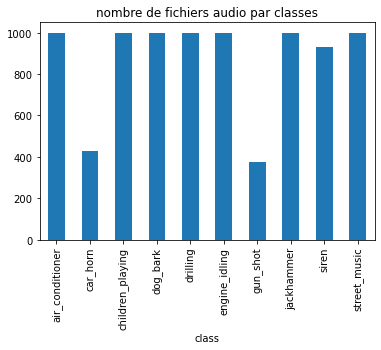

In [12]:
# Nombre de fichiers audio pour chaque classe
labels.groupby('class').size().plot.bar(title="nombre de fichiers audio par classes")

In [13]:
labels['duree'] = labels['end']- labels['start']

<AxesSubplot:title={'center':'duree des fichiers audio par classes'}, xlabel='class'>

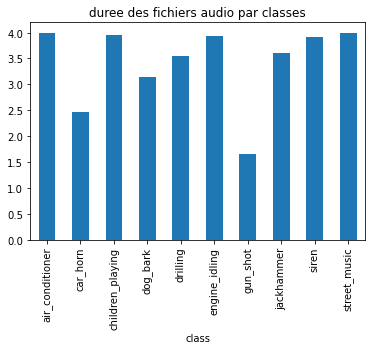

In [14]:
# Durée moyenne des fichiers audio par classes 
moyenne_duree = labels.groupby('class')['duree'].mean()
moyenne_duree.plot.bar(title="duree des fichiers audio par classes")

In [15]:
def display_series(series):  
      display(series.to_frame().transpose())

In [16]:
# Pourcentages de chaque classes dans le dataset 
display_series(labels['class'].value_counts().apply(lambda x : (x/len(labels))*100))

,jackhammer,children_playing,air_conditioner,engine_idling,dog_bark,street_music,drilling,siren,car_horn,gun_shot
class,11.45213,11.45213,11.45213,11.45213,11.45213,11.45213,11.45213,10.639029,4.912964,4.283097


In [17]:
# Lecture d'un des fichiers audio
x, Fs = librosa.load(songs[0], sr=None)
ipd.display(ipd.Audio(data=x, rate=Fs))

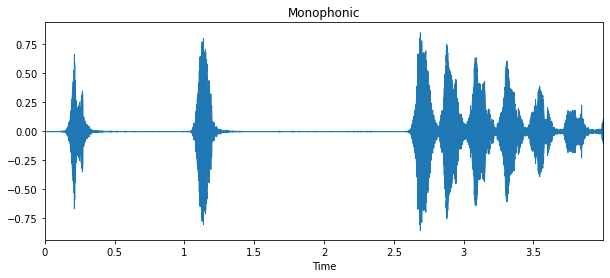

In [18]:
# Affichage du spectre d'un des fichiers audio
signal, sr = librosa.load(songs[0], duration=10) # sr = sampling rate

# plot recording signal
plt.figure(figsize=(10, 4))
librosa.display.waveplot(signal, sr=sr)
plt.title('Monophonic')
plt.show()

In [19]:
# Taille du dataset 
print("la taille du dataset est "+ str(len(labels)) +" fichiers")

la taille du dataset est 8732 fichiers


In [20]:
labels = labels[['slice_file_name','class']]
labels = labels.set_index('slice_file_name')

In [21]:
labels.head()

,class
slice_file_name,
100032-3-0-0.wav,dog_bark
100263-2-0-117.wav,children_playing
100263-2-0-121.wav,children_playing
100263-2-0-126.wav,children_playing
100263-2-0-137.wav,children_playing


In [22]:
df_features["name"] = pd.Series(liste_id_songs)

In [23]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,name
0,-403.967621,94.398071,17.751820,-11.521064,-7.489263,4.073067,-16.308868,-6.735374,-10.601528,-5.113414,...,-1.034300,-2.655814,-0.523793,-2.002407,-2.941532,-3.149520,-1.447502,-2.512676,-2.795815,101415-3-0-2.wav
1,-368.110046,128.744812,28.912741,-21.190054,-15.262681,2.639470,-28.895718,-17.582800,-23.663269,-8.707304,...,-2.410350,-2.949749,1.217798,0.048635,-1.981228,-1.498706,0.567786,-2.555046,-5.152623,101415-3-0-3.wav
2,-422.479034,70.383469,9.934862,0.000618,1.643423,3.714230,-9.649158,-1.782196,-3.811726,-0.288196,...,-1.916761,-3.216991,-1.455734,-1.007524,-2.732134,-2.439353,-0.801251,-2.324180,-1.682428,101415-3-0-8.wav
3,-260.239990,109.351807,-51.811283,-4.287414,-18.306389,2.771631,-6.817822,7.485249,0.031476,12.308299,...,-2.872584,-1.553901,0.787444,-2.719564,0.414522,-2.019426,0.775039,1.656904,-0.095491,102106-3-0-0.wav
4,-386.784851,132.629608,25.220676,22.799538,-10.436672,4.516113,-6.532164,9.258158,-0.426317,7.659397,...,0.536787,0.977274,0.158055,-0.349544,-0.285354,-0.686473,0.383958,0.610550,1.072113,102305-6-0-0.wav


# Préparation du dataset

In [24]:
merged_dataframe = pd.merge(left=df_features, right=labels, left_on='name', right_on='slice_file_name')

In [25]:
merged_dataframe.head() 

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,name,class
0,-403.967621,94.398071,17.751820,-11.521064,-7.489263,4.073067,-16.308868,-6.735374,-10.601528,-5.113414,...,-2.655814,-0.523793,-2.002407,-2.941532,-3.149520,-1.447502,-2.512676,-2.795815,101415-3-0-2.wav,dog_bark
1,-368.110046,128.744812,28.912741,-21.190054,-15.262681,2.639470,-28.895718,-17.582800,-23.663269,-8.707304,...,-2.949749,1.217798,0.048635,-1.981228,-1.498706,0.567786,-2.555046,-5.152623,101415-3-0-3.wav,dog_bark
2,-422.479034,70.383469,9.934862,0.000618,1.643423,3.714230,-9.649158,-1.782196,-3.811726,-0.288196,...,-3.216991,-1.455734,-1.007524,-2.732134,-2.439353,-0.801251,-2.324180,-1.682428,101415-3-0-8.wav,dog_bark
3,-260.239990,109.351807,-51.811283,-4.287414,-18.306389,2.771631,-6.817822,7.485249,0.031476,12.308299,...,-1.553901,0.787444,-2.719564,0.414522,-2.019426,0.775039,1.656904,-0.095491,102106-3-0-0.wav,dog_bark
4,-386.784851,132.629608,25.220676,22.799538,-10.436672,4.516113,-6.532164,9.258158,-0.426317,7.659397,...,0.977274,0.158055,-0.349544,-0.285354,-0.686473,0.383958,0.610550,1.072113,102305-6-0-0.wav,gun_shot


In [26]:
merged_dataframe["y"] = LabelEncoder().fit_transform(merged_dataframe['class']) # The label encoder always sort the class so the mapping is always the same
merged_dataframe

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,name,class,y
0,-403.967621,94.398071,17.751820,-11.521064,-7.489263,4.073067,-16.308868,-6.735374,-10.601528,-5.113414,...,-0.523793,-2.002407,-2.941532,-3.149520,-1.447502,-2.512676,-2.795815,101415-3-0-2.wav,dog_bark,3
1,-368.110046,128.744812,28.912741,-21.190054,-15.262681,2.639470,-28.895718,-17.582800,-23.663269,-8.707304,...,1.217798,0.048635,-1.981228,-1.498706,0.567786,-2.555046,-5.152623,101415-3-0-3.wav,dog_bark,3
2,-422.479034,70.383469,9.934862,0.000618,1.643423,3.714230,-9.649158,-1.782196,-3.811726,-0.288196,...,-1.455734,-1.007524,-2.732134,-2.439353,-0.801251,-2.324180,-1.682428,101415-3-0-8.wav,dog_bark,3
3,-260.239990,109.351807,-51.811283,-4.287414,-18.306389,2.771631,-6.817822,7.485249,0.031476,12.308299,...,0.787444,-2.719564,0.414522,-2.019426,0.775039,1.656904,-0.095491,102106-3-0-0.wav,dog_bark,3
4,-386.784851,132.629608,25.220676,22.799538,-10.436672,4.516113,-6.532164,9.258158,-0.426317,7.659397,...,0.158055,-0.349544,-0.285354,-0.686473,0.383958,0.610550,1.072113,102305-6-0-0.wav,gun_shot,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-355.596924,105.955048,-48.766628,57.914871,-4.303929,19.364935,2.594625,10.438691,4.662246,10.513984,...,-0.979985,-1.907905,2.495256,0.844629,0.017631,-1.676227,0.225263,99500-2-0-23.wav,children_playing,2
8728,-372.619904,120.041092,-52.157391,52.686016,2.468143,30.225056,3.270729,5.431655,0.141910,16.509537,...,-1.131930,-2.051791,-1.799522,-0.874247,0.598182,-1.684182,0.555801,99500-2-0-29.wav,children_playing,2
8729,-342.279907,113.442352,-62.702427,62.841831,-5.029973,24.582609,1.372840,1.644158,2.130837,7.627467,...,-0.151377,-2.021508,0.718946,-0.702763,-1.490733,-0.708686,-2.425671,99500-2-0-39.wav,children_playing,2
8730,-351.106049,114.208069,-57.208488,63.083256,-5.599070,24.483217,2.186491,7.885724,4.597743,14.235478,...,1.603643,0.195600,1.322528,0.275680,-0.214784,-0.748009,-0.618953,99500-2-0-41.wav,children_playing,2


In [27]:
LabelEncoder().fit_transform(merged_dataframe['class'])

array([3, 3, 3, ..., 2, 2, 2])

In [28]:
x = merged_dataframe.iloc[:, :40]
y = merged_dataframe["y"]
file_name = merged_dataframe["name"]

# Partie création du modèle 

## Split train test

In [29]:
random_state = 42
test_size=0.1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
train_file_name, test_file_name = train_test_split(file_name, test_size=test_size, random_state=random_state) 

In [30]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
y_train

(7858, 40) (7858,) (874, 40) (874,)


1558    0
7149    5
472     7
6394    4
6074    5
       ..
5734    1
5191    3
5390    2
860     7
7270    8
Name: y, Length: 7858, dtype: int32

In [61]:
print(train_file_name)
print(test_file_name)

1558     73524-0-0-92.wav
7149     113202-5-0-6.wav
472     180937-7-1-10.wav
6394     130961-4-1-1.wav
6074      62564-5-0-0.wav
              ...        
5734     162702-1-1-0.wav
5191     34771-3-0-14.wav
5390      80806-2-0-2.wav
860       98223-7-3-0.wav
7270     133473-8-0-1.wav
Name: name, Length: 7858, dtype: object
6770    201988-5-0-21.wav
3534     110621-7-0-1.wav
8556      58937-4-0-0.wav
7870     76266-2-0-55.wav
1226     171478-9-0-4.wav
              ...        
1732     102871-8-0-9.wav
3964    174032-2-0-22.wav
6091     63724-0-0-14.wav
1832     14387-9-0-11.wav
4680     115239-9-0-5.wav
Name: name, Length: 874, dtype: object


In [32]:
y_train

1558    0
7149    5
472     7
6394    4
6074    5
       ..
5734    1
5191    3
5390    2
860     7
7270    8
Name: y, Length: 7858, dtype: int32

In [33]:
nb_labels = len(set(y_train.append(y_test)))
nb_labels_train = len(set(y_train))
nb_labels_test = len(set(y_test))
print(f"On a {nb_labels} classes différentes, {nb_labels_train} dans le train, {nb_labels_test} dans le test")

On a 10 classes différentes, 10 dans le train, 10 dans le test


<AxesSubplot:title={'center':'nombre de fichiers audio par classes'}, xlabel='y'>

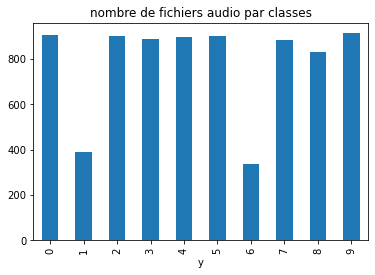

In [34]:
y_train.groupby(y_train).size().plot.bar(title="nombre de fichiers audio par classes")

<AxesSubplot:title={'center':'nombre de fichiers audio par classes'}, xlabel='y'>

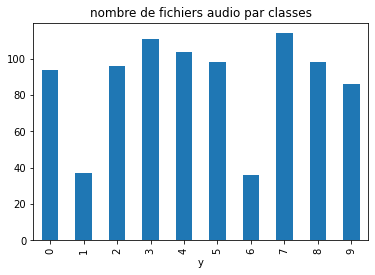

In [35]:
y_test.groupby(y_test).size().plot.bar(title="nombre de fichiers audio par classes")

## Modèle d'apprentissage

### Keras - Deep learning

In [36]:
def plot_history(history):
    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='acc train')
    plt.plot(history.history['val_accuracy'], label='val_acc test')
    plt.plot(history.history['top2'], label='top2 train')
    plt.plot(history.history['val_top2'], label='val_top2 test')
    plt.plot(history.history['top3'], label='top3 train')
    plt.plot(history.history['val_top3'], label='val_top3 test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label ='test', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [37]:
def print_result(history):
    val_accuracy = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    print(f"Le modèle a une loss de {val_loss:5.4f} et une accuracy de {val_accuracy*100:5.2f}% sur le dataset de test")

In [38]:
model = keras.Sequential([
  keras.layers.Dense(256, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

In [39]:
start = time.time()
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=1)
stop = time.time()

Train on 7858 samples, validate on 874 samples
Epoch 1/100
7858/7858 [==============================] - 1s 173us/sample - loss: 4.0938 - accuracy: 0.1833 - top2: 0.3211 - top3: 0.4399 - val_loss: 2.0643 - val_accuracy: 0.2471 - val_top2: 0.4039 - val_top3: 0.5343
Epoch 2/100
7858/7858 [==============================] - 1s 69us/sample - loss: 2.0881 - accuracy: 0.2618 - top2: 0.4319 - top3: 0.5640 - val_loss: 1.7886 - val_accuracy: 0.3913 - val_top2: 0.5812 - val_top3: 0.7151
Epoch 3/100
7858/7858 [==============================] - 1s 70us/sample - loss: 1.8636 - accuracy: 0.3402 - top2: 0.5261 - top3: 0.6603 - val_loss: 1.5232 - val_accuracy: 0.4840 - val_top2: 0.6716 - val_top3: 0.7769
Epoch 4/100
7858/7858 [==============================] - 1s 68us/sample - loss: 1.6814 - accuracy: 0.4178 - top2: 0.6032 - top3: 0.7199 - val_loss: 1.3614 - val_accuracy: 0.5446 - val_top2: 0.7265 - val_top3: 0.8261
Epoch 5/100
7858/7858 [==============================] - 1s 68us/sample - loss: 1.5132 -

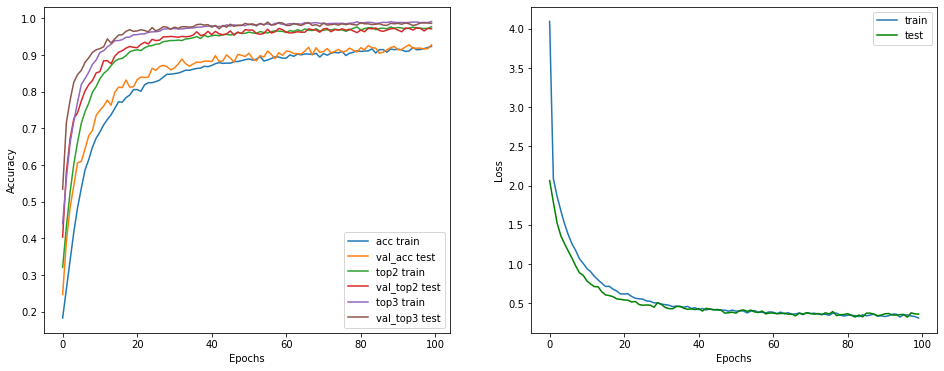

Le modèle a une loss de 0.3600 et une accuracy de 92.79% sur le dataset de test
Training time: 56.50s


In [40]:
plot_history(history)
print_result(history)
print(f"Training time: {stop - start:5.2f}s")

In [41]:
#Sauvegarde du modèle
model.save("../model/urbansound8k.h5")

### Test avec différents ratio de split

In [42]:
def test_split_ratio(test_size):
    # test_size compris entre 0.1 et 0.5
    if test_size > 0.5: test_size = 0.5
    if test_size < 0.1: test_size = 0.1

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    train_file_name, test_file_name = train_test_split(file_name, test_size=test_size, random_state=random_state)

    model = keras.Sequential([
    keras.layers.Dense(256, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(nb_labels, activation='softmax'),
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                    metrics=['accuracy', 
                    keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                    keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])

    start = time.time()
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=0)
    stop = time.time()

    print(f"\ntest_size: {test_size}")
    plot_history(history)
    print_result(history)
    print(f"Training time: {stop - start:5.2f}s")


test_size: 0.1


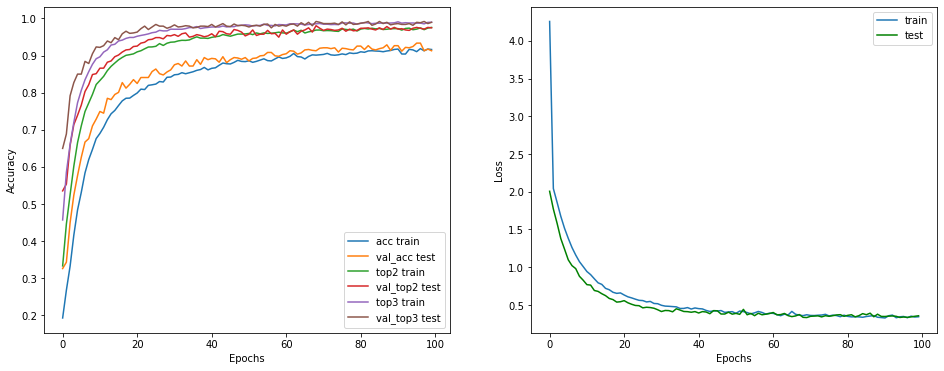

Le modèle a une loss de 0.3570 et une accuracy de 91.30% sur le dataset de test
Training time: 50.89s

test_size: 0.2


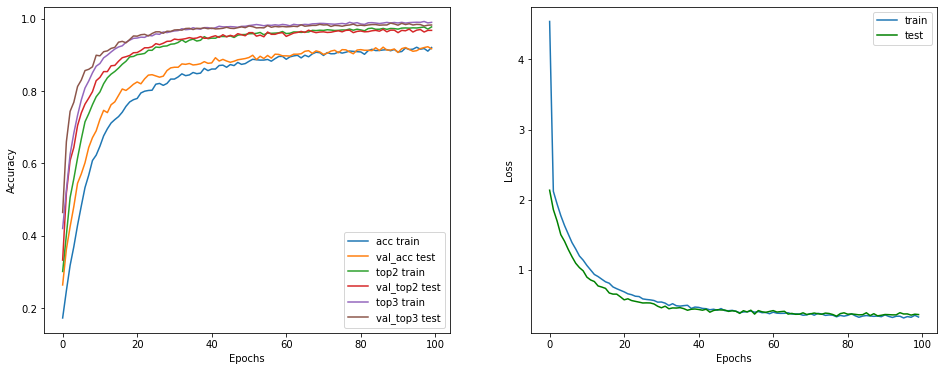

Le modèle a une loss de 0.3634 et une accuracy de 91.64% sur le dataset de test
Training time: 47.99s

test_size: 0.3


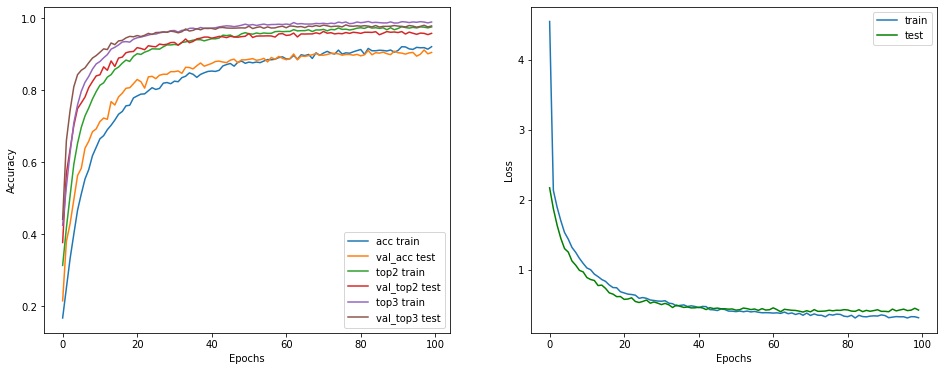

Le modèle a une loss de 0.4258 et une accuracy de 90.53% sur le dataset de test
Training time: 35.24s

test_size: 0.4


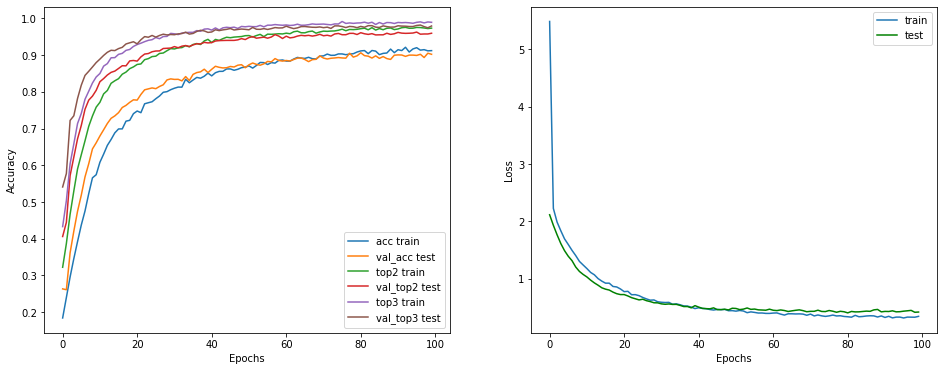

Le modèle a une loss de 0.4183 et une accuracy de 90.21% sur le dataset de test
Training time: 43.98s

test_size: 0.5


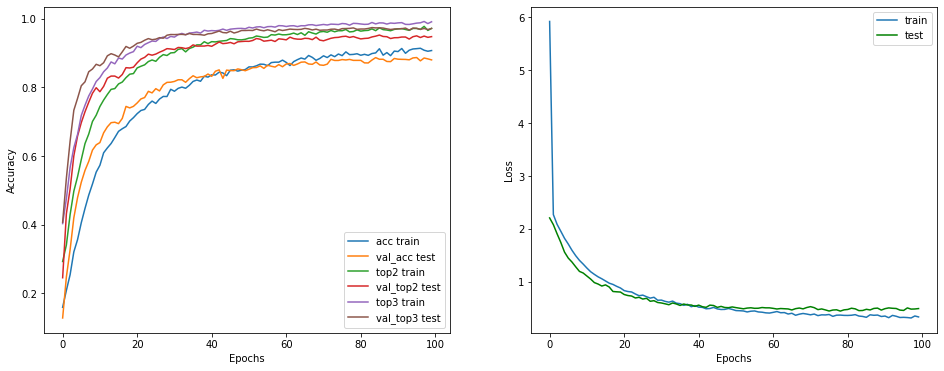

Le modèle a une loss de 0.4941 et une accuracy de 88.02% sur le dataset de test
Training time: 39.90s


In [43]:
for ratio in range (1, 6, 1):
    test_split_ratio(ratio/10)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)
train_file_name, test_file_name = train_test_split(file_name, test_size=0.1, random_state=random_state)

## Autres modèles

In [45]:
# Modèle très petit avec 1 couche cachée
model_verysmall = keras.Sequential([
  keras.layers.Dense(40, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(20, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model_verysmall.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model_verysmall.summary()

start = time.time()
history_verysmall = model_verysmall.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=1)
stop = time.time()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 40)                1640      
_________________________________________________________________
dropout_18 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_19 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                210       
Total params: 2,670
Trainable params: 2,670
Non-trainable params: 0
_________________________________________________________________
Train on 7858 samples, validate on 874 samples
Epoch 1/100
7858/7858 [==============================] - 1s 87us/sample

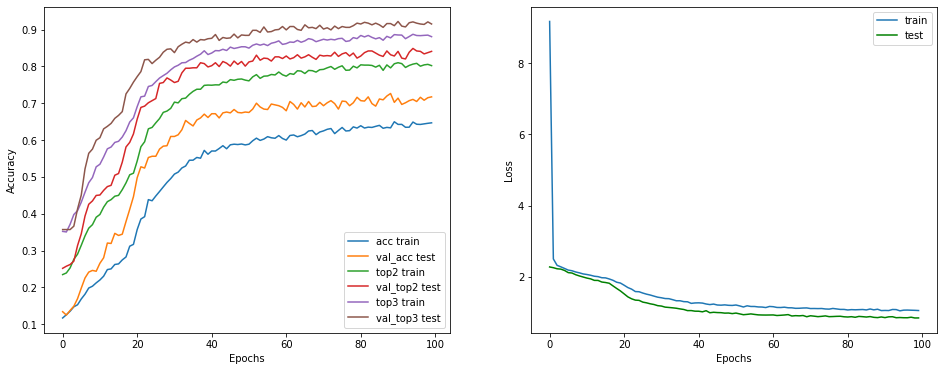

Le modèle a une loss de 0.8426 et une accuracy de 71.74% sur le dataset de test
Training time: 24.73s


In [46]:
plot_history(history_verysmall)
print_result(history_verysmall)
print(f"Training time: {stop - start:5.2f}s")

In [47]:
# Modèle petit avec 2 couches cachées
model_small = keras.Sequential([
  keras.layers.Dense(70, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(35, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(20, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model_small.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model_small.summary()

start = time.time()
history_small = model_small.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=1)
stop = time.time()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 70)                2870      
_________________________________________________________________
dropout_20 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 35)                2485      
_________________________________________________________________
dropout_21 (Dropout)         (None, 35)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 20)                720       
_________________________________________________________________
dropout_22 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)               

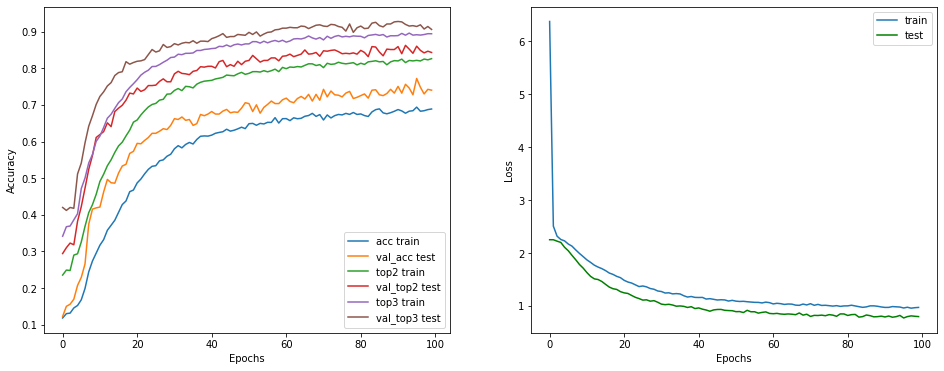

Le modèle a une loss de 0.7983 et une accuracy de 74.03% sur le dataset de test
Training time: 29.90s


In [48]:
plot_history(history_small)
print_result(history_small)
print(f"Training time: {stop - start:5.2f}s")

In [49]:
# Modèle de taille moyenne avec 2 couches cachées
model_medium = keras.Sequential([
  keras.layers.Dense(200, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model_medium.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model_medium.summary()

start = time.time()
history_medium = model_medium.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=1)
stop = time.time()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 200)               8200      
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)               

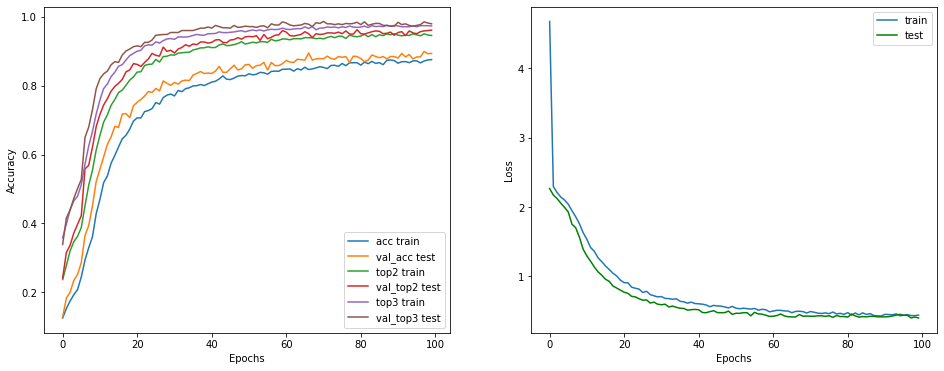

Le modèle a une loss de 0.4000 et une accuracy de 89.36% sur le dataset de test
Training time: 41.76s


In [50]:
plot_history(history_medium)
print_result(history_medium)
print(f"Training time: {stop - start:5.2f}s")

In [51]:
# Modèle de grosse taille avec 2 couches cachées
model_big = keras.Sequential([
  keras.layers.Dense(512, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model_big.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model_big.summary()

start = time.time()
history_big = model_big.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=1)
stop = time.time()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 512)               20992     
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)               

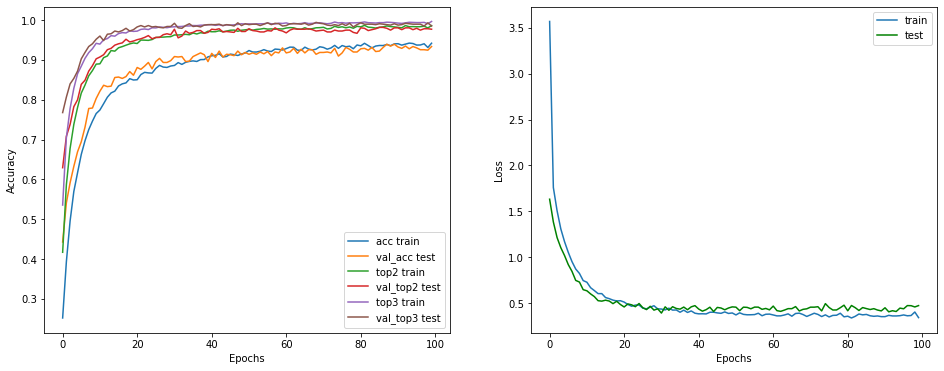

Le modèle a une loss de 0.4722 et une accuracy de 93.36% sur le dataset de test
Training time: 89.16s


In [52]:
plot_history(history_big)
print_result(history_big)
print(f"Training time: {stop - start:5.2f}s")

## Test de la prédiction

In [65]:
model = keras.models.load_model("../model/urbansound8k.h5")

In [66]:
test_file_name

6770    201988-5-0-21.wav
3534     110621-7-0-1.wav
8556      58937-4-0-0.wav
7870     76266-2-0-55.wav
1226     171478-9-0-4.wav
              ...        
1732     102871-8-0-9.wav
3964    174032-2-0-22.wav
6091     63724-0-0-14.wav
1832     14387-9-0-11.wav
4680     115239-9-0-5.wav
Name: name, Length: 874, dtype: object

In [67]:
test_sound = list(test_file_name)[0]
test_sound

'201988-5-0-21.wav'

In [68]:
test_sound_path = [*Path('../data').rglob(test_sound)][0]
test_sound_path

WindowsPath('../data/urbansound8k/fold7/201988-5-0-21.wav')

In [69]:
test_sound_features = extract_features(test_sound_path)
test_sound_features

array([-2.62297455e+02,  1.02538452e+02,  1.70994511e+01,  5.66878967e+01,
       -1.66913643e+01,  2.65250015e+01,  1.64341354e+01,  2.83173485e+01,
       -1.88196599e+00,  1.39274969e+01, -9.33466148e+00,  1.06761732e+01,
       -1.40337002e+00, -5.72708130e+00, -4.31368494e+00,  1.02835245e+01,
       -8.34976196e+00,  4.17427778e+00, -3.21503854e+00, -5.35010219e-01,
       -5.80739546e+00,  3.94845843e+00, -6.98430157e+00,  1.18986022e+00,
       -5.85781765e+00, -2.74179626e+00, -5.66635418e+00,  2.20405273e-02,
       -2.49795794e+00, -3.69260955e+00, -5.83548403e+00, -2.12411070e+00,
       -4.47622061e+00, -3.04321289e+00, -2.86911488e+00, -2.64647841e+00,
       -3.74922705e+00, -8.61217499e-01, -1.81000516e-01, -2.91391158e+00],
      dtype=float32)

In [70]:
test_sound_features = test_sound_features.reshape(1, 40)
test_sound_features.shape

(1, 40)

In [71]:
prediction = model.predict(test_sound_features)[0]
prediction

array([3.7166754e-12, 9.1910732e-12, 6.4365913e-12, 6.0963967e-10,
       1.4297331e-13, 1.0000000e+00, 3.0065659e-17, 7.0871065e-18,
       1.0280888e-09, 4.6125713e-08], dtype=float32)

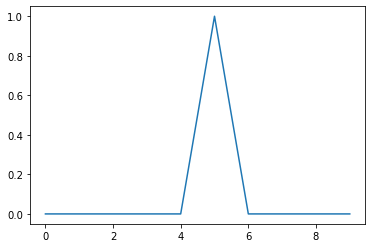

In [72]:
plt.plot(prediction) 

In [78]:
labels_class = labels.reset_index()
labels_class.loc[labels_class['slice_file_name']==test_sound]

,slice_file_name,class
5227,201988-5-0-21.wav,engine_idling


In [74]:
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

In [75]:
predicted_classe_index = np.argmax(prediction)
predicted_classe_index

5

In [76]:
predicted_classe = classes[predicted_classe_index]
predicted_classe

'engine_idling'

In [77]:
print(f'La prédiction de la classe pour le fichier {test_sound} est : {predicted_classe} avec {prediction[predicted_classe_index]*100}% de précision.')

La prédiction de la classe pour le fichier 201988-5-0-21.wav est : engine_idling avec 100.0% de précision.
